In [1]:
%load_ext autoreload
%autoreload

from retro_branching.utils import get_most_recent_checkpoint_foldername, PlotAesthetics

import glob
import gzip
import pickle
from collections import defaultdict
import copy
import numpy as np
import scipy.stats as st
import math
import sigfig

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from tabulate import tabulate

In [47]:
n_rows = 500
n_cols = 1000

scip_params = [
                'gasse_2019', 
                'dfs',
                'bfs',
                ]

agent = 'dqn_gnn_1481_checkpoint_166'
AGENT_NAME = 'Retro'

BASELINE = 'pseudocost'
# BASELINE = 'gnn_361_checkpoint_139'

verbose = True

In [48]:
scip_param_to_display_name = {
    'gasse_2019': 'Default',
    'dfs': 'DFS',
    'bfs': 'BFS'
}

In [49]:
agent_to_path = {}
for scip in scip_params:
    agent_to_path[AGENT_NAME+f'-{scip_param_to_display_name[scip]}'] = f'/scratch/datasets/retro_branching/instances/set_covering_n_rows_{n_rows}_n_cols_{n_cols}/scip_{scip}/baselines/dqn_gnn_1481_checkpoint_166/rl_validator/rl_validator_1/'
    agent_to_path[f'{BASELINE}-{scip_param_to_display_name[scip]}'] = f'/scratch/datasets/retro_branching/instances/set_covering_n_rows_{n_rows}_n_cols_{n_cols}/scip_{scip}/baselines/{BASELINE}/rl_validator/rl_validator_1/'
display(agent_to_path)

{'Retro-Default': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/scip_gasse_2019/baselines/dqn_gnn_1481_checkpoint_166/rl_validator/rl_validator_1/',
 'pseudocost-Default': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/scip_gasse_2019/baselines/pseudocost/rl_validator/rl_validator_1/',
 'Retro-DFS': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/scip_dfs/baselines/dqn_gnn_1481_checkpoint_166/rl_validator/rl_validator_1/',
 'pseudocost-DFS': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/scip_dfs/baselines/pseudocost/rl_validator/rl_validator_1/',
 'Retro-BFS': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/scip_bfs/baselines/dqn_gnn_1481_checkpoint_166/rl_validator/rl_validator_1/',
 'pseudocost-BFS': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/scip_bfs/baselines/pseudocost/rl_vali

In [50]:
# load agent logs
agent_to_log = {}
agent_name_to_display_name = {}
for display_name, path in agent_to_path.items():
    path += get_most_recent_checkpoint_foldername(path)
    with gzip.open(*glob.glob(path+'/*log.pkl'), 'rb') as f:
        log = pickle.load(f)
    _agent_name = log['agent_names'][0]
    scip = display_name.split('-')[-1]
    agent_name = f'{_agent_name}-{scip}'
    log[agent_name] = copy.deepcopy(log[_agent_name])
#     agent_name += f'-{display_name.split('-')[-1]}'
    agent_to_log[agent_name] = log
    agent_name_to_display_name[agent_name] = display_name
    
    num_instances = len(log[agent_name]["num_nodes"])
    print(f'Num evaluation instances solved in {display_name} agent log file: {num_instances}')

Num evaluation instances solved in Retro-Default agent log file: 100
Num evaluation instances solved in pseudocost-Default agent log file: 100
Num evaluation instances solved in Retro-DFS agent log file: 100
Num evaluation instances solved in pseudocost-DFS agent log file: 100
Num evaluation instances solved in Retro-BFS agent log file: 100
Num evaluation instances solved in pseudocost-BFS agent log file: 100


In [51]:
# get stats for each agent
agent_to_stats = {agent: defaultdict(lambda: 0) for agent in agent_to_log.keys()}
for agent, log in agent_to_log.items():
    agent_to_stats[agent]['num_nodes'] = [int(np.abs(np.array(nodes)).sum()) for nodes in log[agent]['num_nodes']]
    agent_to_stats[agent]['lp_iterations'] = [int(np.abs(np.array(nodes)).sum()) for nodes in log[agent]['lp_iterations']]
print(agent_to_stats)

{'dqn_gnn_1481_checkpoint_166-Default': defaultdict(<function <dictcomp>.<lambda> at 0x7fdd18a88950>, {'num_nodes': [42, 14, 6, 52, 6, 15, 20, 68, 51, 18, 50, 2, 69, 6, 14, 54, 24, 16, 14, 104, 38, 148, 60, 142, 57, 10, 50, 20, 16, 10, 15, 8, 62, 20, 7, 10, 58, 183, 14, 60, 156, 16, 6, 10, 161, 4, 22, 12, 52, 26, 68, 98, 82, 70, 68, 220, 58, 8, 69, 8, 203, 16, 146, 62, 24, 88, 53, 34, 10, 14, 8, 104, 258, 44, 48, 40, 8, 4, 16, 84, 58, 80, 12, 92, 52, 6, 16, 46, 26, 214, 10, 20, 14, 177, 8, 18, 28, 12, 22, 28], 'lp_iterations': [2990, 683, 209, 1764, 292, 918, 704, 3650, 4076, 1473, 3554, 65, 3849, 163, 930, 3690, 1862, 1017, 796, 5351, 3630, 8356, 4617, 6788, 4929, 387, 2174, 750, 935, 345, 763, 96, 3328, 803, 369, 334, 5259, 15634, 408, 4330, 8304, 594, 369, 436, 11978, 102, 1267, 426, 2759, 1021, 4436, 7004, 3416, 5002, 5896, 15814, 2087, 268, 8248, 588, 12778, 1167, 7898, 3650, 1280, 3772, 3324, 2070, 413, 425, 367, 7473, 16664, 5195, 2023, 2087, 255, 168, 550, 4381, 3176, 3057, 392

In [52]:
# get stats for each agent
agent_to_scip_to_stats = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0)))
for _agent, log in agent_to_log.items():
    agent, scip = _agent.split('-')
    agent_to_scip_to_stats[agent][scip]['num_nodes'] = np.mean([int(np.abs(np.array(nodes)).sum()) for nodes in log[agent]['num_nodes']])
    agent_to_scip_to_stats[agent][scip]['lp_iterations'] = np.mean([int(np.abs(np.array(nodes)).sum()) for nodes in log[agent]['lp_iterations']])
display(agent_to_scip_to_stats.keys())
display(agent_to_scip_to_stats)

dict_keys(['dqn_gnn_1481_checkpoint_166', 'pseudocost'])

defaultdict(<function __main__.<lambda>()>,
            {'dqn_gnn_1481_checkpoint_166': defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {'Default': defaultdict(<function __main__.<lambda>.<locals>.<lambda>.<locals>.<lambda>()>,
                                      {'num_nodes': 50.5,
                                       'lp_iterations': 3199.39}),
                          'DFS': defaultdict(<function __main__.<lambda>.<locals>.<lambda>.<locals>.<lambda>()>,
                                      {'num_nodes': 55.73,
                                       'lp_iterations': 2324.57}),
                          'BFS': defaultdict(<function __main__.<lambda>.<locals>.<lambda>.<locals>.<lambda>()>,
                                      {'num_nodes': 50.81,
                                       'lp_iterations': 3626.65})}),
             'pseudocost': defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {'Default': de

In [53]:
# normalise agent stats with baseline
normalised_agentscip_to_stats = defaultdict(lambda: defaultdict(lambda: 0))
for agent in agent_to_scip_to_stats.keys():
    if agent != BASELINE:
        for scip in agent_to_scip_to_stats[agent].keys():
            agentscip = f'{AGENT_NAME}-{scip}'
            for metric in agent_to_scip_to_stats[agent][scip].keys():
                normalised_agentscip_to_stats[agentscip][metric] = np.array(agent_to_scip_to_stats[agent][scip][metric]) / np.array(agent_to_scip_to_stats[BASELINE][scip][metric])
print(normalised_agentscip_to_stats)

defaultdict(<function <lambda> at 0x7fda6dd81cb0>, {'Retro-Default': defaultdict(<function <lambda>.<locals>.<lambda> at 0x7fda6d7c6dd0>, {'num_nodes': 0.6043561512685496, 'lp_iterations': 0.8377098928836068}), 'Retro-DFS': defaultdict(<function <lambda>.<locals>.<lambda> at 0x7fdd18d417a0>, {'num_nodes': 0.6311438278595697, 'lp_iterations': 0.7916448143632636}), 'Retro-BFS': defaultdict(<function <lambda>.<locals>.<lambda> at 0x7fdd18d41e60>, {'num_nodes': 0.6192565508836076, 'lp_iterations': 0.862180454881525})})


In [54]:
# Create dataframes (from above dict) for data manipulation and seaborn plotting (use display_name for legends)
_df = defaultdict(list)
for agent in normalised_agentscip_to_stats.keys():
    for stat in normalised_agentscip_to_stats[agent].keys():
        try:
            for el in normalised_agentscip_to_stats[agent][stat]:
                _df[stat].append(el)
        except TypeError:
            # non-iterable, is already an element
            _df[stat].append(normalised_agentscip_to_stats[agent][stat])

for agent in normalised_agentscip_to_stats.keys():
    try:
        for _ in range(len(normalised_agentscip_to_stats[agent][metric])):
            _df['Agent'].append(agent)
    except TypeError:
        # only one value stored so not iterable
        _df['Agent'].append(agent)
                        
for key, val in _df.items():
    print(key, len(val))
df = pd.DataFrame(_df)
if verbose:
    print(tabulate(df, headers='keys', tablefmt='psql', showindex=False))

num_nodes 3
lp_iterations 3
Agent 3
+-------------+-----------------+---------------+
|   num_nodes |   lp_iterations | Agent         |
|-------------+-----------------+---------------|
|    0.604356 |        0.83771  | Retro-Default |
|    0.631144 |        0.791645 | Retro-DFS     |
|    0.619257 |        0.86218  | Retro-BFS     |
+-------------+-----------------+---------------+


In [55]:
# config
estimator = np.mean # np.mean np.median
# estimator = np.median
# estimator = st.iqr
# estimator = st.gmean
# context = 'paper'
# style = 'white'
# font_scale = 2
# palette = 'hls'
# ci = 68
ci = None
errcolor = 'gray'
capsize = 0.05

# xaxis_label = 'Agent'
xaxis_label = ''

y_offset = 0 # 165x230
# y_offsert = 0.3
# y_offset = 5 # 500x1000
# y_offset = 150

# loc = 'bottom'
loc = 'top'

ylog = False

xlog = False

display_values = True

# scaling_factor = 0.6
# width_scaling_factor = 1
# height_scaling_factor = 1
scaling_factor = 1
# width_scaling_factor = 1
width_scaling_factor = 1.4
height_scaling_factor = 0.5

aesthetics = PlotAesthetics()
aesthetics.set_icml_paper_plot_aesthetics()

In [56]:
def show_values_on_bars(axs, sigfigs=2, y_offset=0, loc='top'):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            if loc == 'top':
                _x = p.get_x() + p.get_width() / 2
    #             _y = p.get_y() + p.get_height()
    #             _y = p.get_y() + y_offset
                _y = p.get_height() + y_offset
                value = sigfig.round(p.get_height(), sigfigs=sigfigs)
                ax.text(_x, _y, value, ha="center") 
            elif loc == 'bottom':
                _x = p.get_x() + p.get_width() / 2
    #             _y = p.get_y() + p.get_height()
                _y = p.get_y() + y_offset
                value = sigfig.round(p.get_height(), sigfigs=sigfigs)
                ax.text(_x, _y, value, ha="center") 
            else:
                raise Exception(f'Unrecognised loc {loc}')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

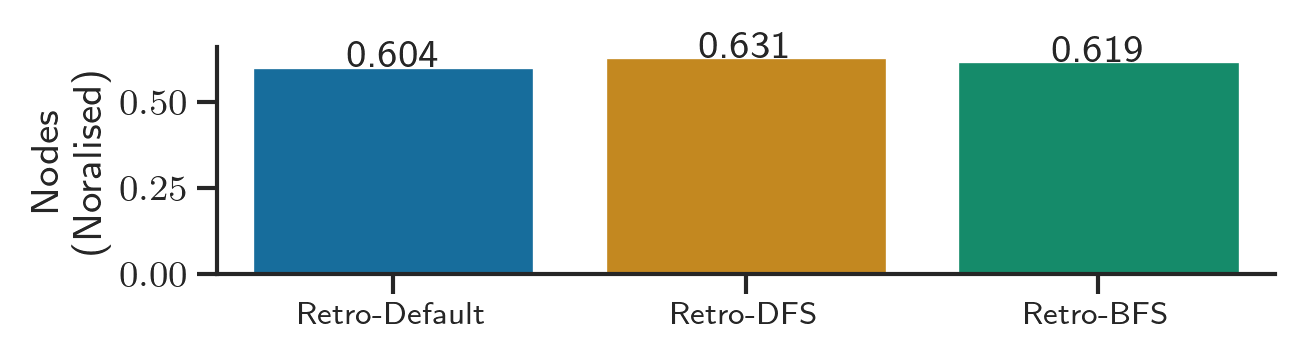

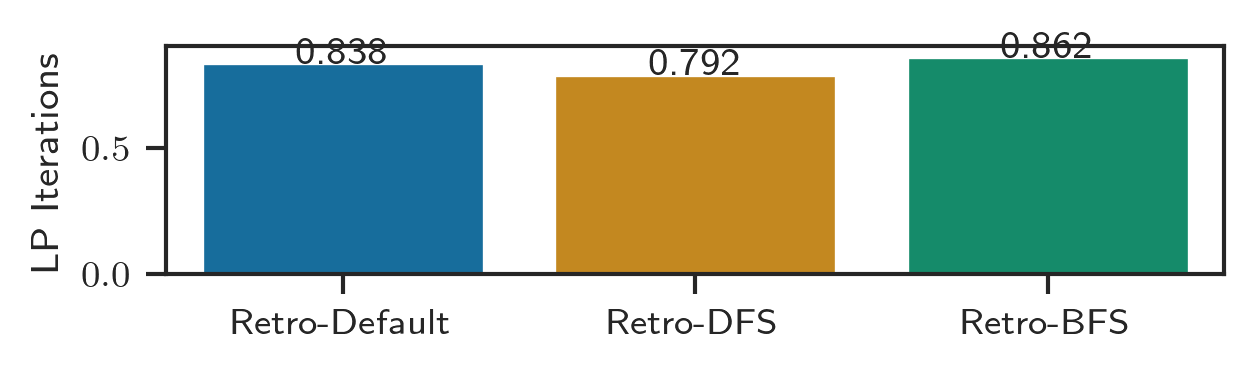

In [57]:
# sns.set_theme(font_scale=font_scale,
#               context=context,
#               style=style,
#               palette=palette)

f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
g = sns.barplot(data=df,
                x='Agent',
                y='num_nodes',
                estimator=estimator,
                ci=ci,
                errcolor=errcolor,
                capsize=capsize)
g.set_xlabel(xaxis_label)
g.set_ylabel('Nodes\n(Noralised)')
ax.tick_params(axis='both', which='major', pad=2)
plt.xticks(fontsize=7.5)
ax.xaxis.labelpad = 2
# ax.xaxis.label.set_size(2)
ax.yaxis.labelpad = 2
sns.despine(ax=ax) # remove top and right spines
if ylog:
    g.set(yscale='log')
if xlog:
    g.set(xscale='log')
if display_values:
    show_values_on_bars(ax, sigfigs=3, y_offset=y_offset, loc=loc)
plt.gcf().patch.set_alpha(0.0)
plt.show()

f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
g = sns.barplot(data=df,
                x='Agent',
                y='lp_iterations',
                estimator=estimator,
                ci=ci,
                errcolor=errcolor,
                capsize=capsize)
g.set_xlabel(xaxis_label)
g.set_ylabel('LP Iterations')
if display_values:
    show_values_on_bars(ax, sigfigs=3, loc=loc)
plt.show()

if 'calibrated_inference_time' in df.columns:
    f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
    g = sns.barplot(data=df,
                    x='Agent',
                    y='calibrated_inference_time',
                    estimator=estimator,
                    ci=ci,
                    errcolor=errcolor,
                    capsize=capsize)
    g.set_xlabel(xaxis_label)
    g.set_ylabel('Cal. Inference Time (s)')
    if display_values:
        show_values_on_bars(ax, sigfigs=3, loc=loc)
    plt.show()

if 'calibrated_step_time' in df.columns:
    f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
    g = sns.barplot(data=df,
                    x='Agent',
                    y='calibrated_step_time',
                    estimator=estimator,
                    ci=ci,
                    errcolor=errcolor,
                    capsize=capsize)
    g.set_xlabel(xaxis_label)
    g.set_ylabel('Cal. Step Time (s)')
    if display_values:
        show_values_on_bars(ax, sigfigs=3, loc=loc)
    plt.show()

if 'calibrated_solve_time' in df.columns:
    f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
    g = sns.barplot(data=df,
                    x='Agent',
                    y='calibrated_solve_time',
                    estimator=estimator,
                    ci=ci,
                    errcolor=errcolor,
                    capsize=capsize)
    g.set_xlabel(xaxis_label)
    g.set_ylabel('Cal. Solve Time (s)')
    if display_values:
        show_values_on_bars(ax, sigfigs=3, loc=loc)
    plt.show()